In [3]:
import kagglehub

In [4]:
kagglehub.dataset_download('meowmeowmeowmeowmeow/gtsrb-german-traffic-sign')

'/kaggle/input/gtsrb-german-traffic-sign'

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import pathlib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# from tensorflow.python.keras.preprocessing.image
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [6]:
data_dir = '/kaggle/input/gtsrb-german-traffic-sign'
train_csv = pd.read_csv(os.path.join(data_dir, "Train.csv"))
print("Dataset Loaded!", train_csv.shape)

Dataset Loaded! (39209, 8)


In [7]:
X, y = [], []

for i, row in train_csv.iterrows():
  img_path = os.path.join(data_dir, row["Path"])
  image = cv2.imread(img_path)
  image = cv2.resize(image, (32, 32))
  X.append(image)
  y.append(row["ClassId"])

In [8]:
X = np.array(X) / 255.0

In [9]:
from tensorflow.python.keras.utils.np_utils import to_categorical

y = to_categorical(y)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Data split done! Train shape: ", X_train.shape, ", Test Shape: ", X_test.shape)

Data split done! Train shape:  (31367, 32, 32, 3) , Test Shape:  (7842, 32, 32, 3)


In [11]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.1),       # ~10 degrees
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.1, 0.1)  # width & height shift
])

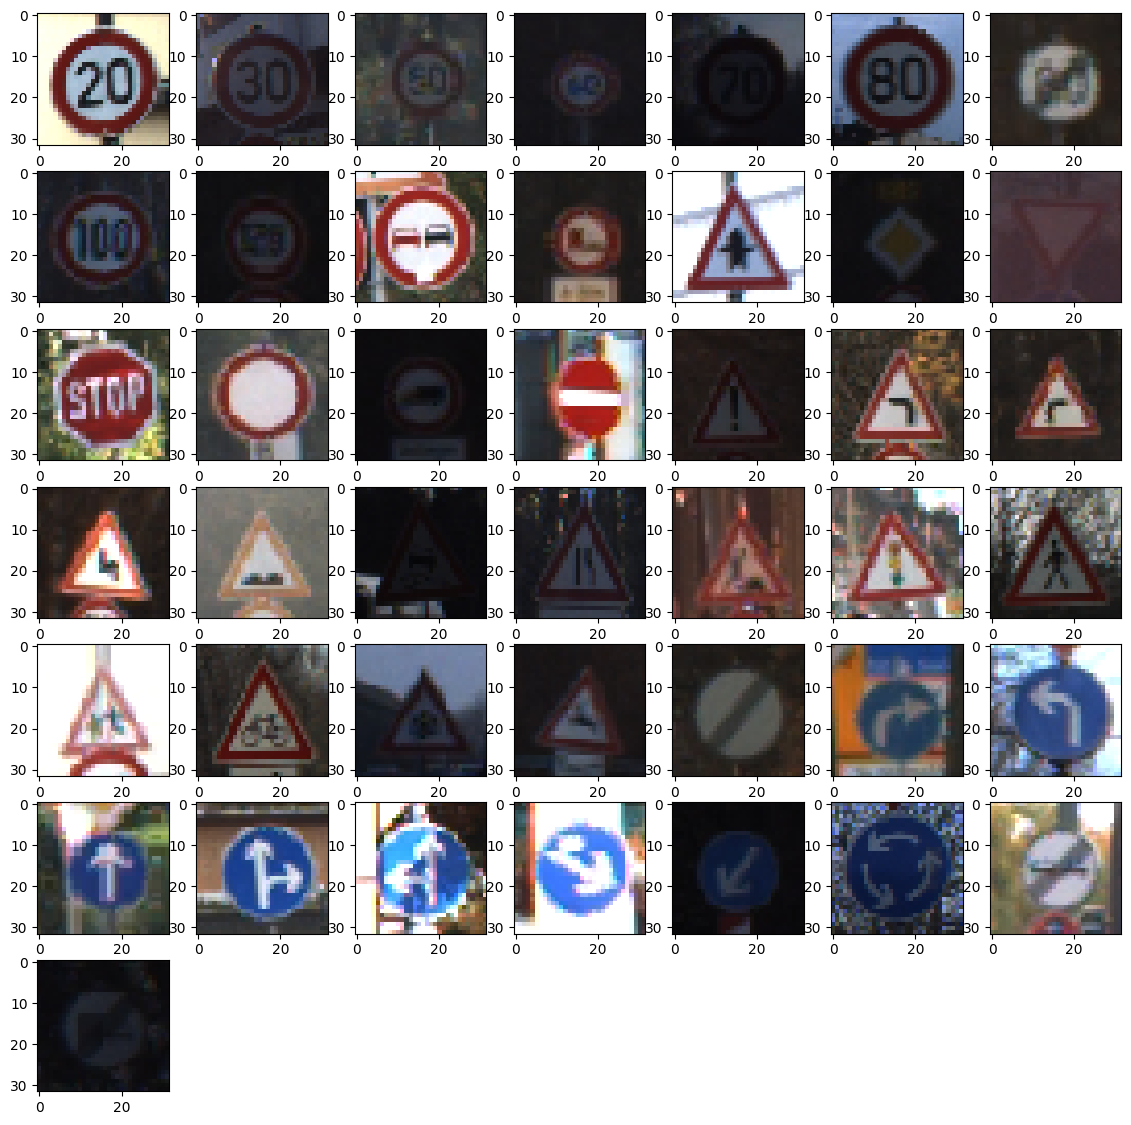

In [12]:
from tensorflow.keras.utils import load_img

NUM_CATEGORIES = 43
IMG_WIDTH, IMG_HEIGHT = 32, 32
train_path = os.path.join(data_dir, "Train")
img_dir = pathlib.Path(train_path)
plt.figure(figsize=(14, 14))

for i in range(NUM_CATEGORIES):
  plt.subplot(7, 7, i+1)
  sign = list(img_dir.glob(f'{i}/*'))[0]
  img = load_img(sign, target_size=(IMG_WIDTH, IMG_HEIGHT))
  plt.imshow(img)

plt.show()

In [13]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(43, activation='softmax')
])

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Step 1: Create tf.data.Dataset from arrays
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Step 2: Batch and shuffle
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32)
test_dataset = test_dataset.batch(32)

# Step 3: Apply data augmentation using .map()
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

In [16]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=15
)

Epoch 1/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.1665 - loss: 3.0604 - val_accuracy: 0.5766 - val_loss: 1.2859
Epoch 2/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.5273 - loss: 1.4643 - val_accuracy: 0.8132 - val_loss: 0.5998
Epoch 3/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7004 - loss: 0.9147 - val_accuracy: 0.8896 - val_loss: 0.3337
Epoch 4/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.7942 - loss: 0.6454 - val_accuracy: 0.9338 - val_loss: 0.2143
Epoch 5/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.8460 - loss: 0.4961 - val_accuracy: 0.9482 - val_loss: 0.1764
Epoch 6/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8682 - loss: 0.4099 - val_accuracy: 0.9486 - val_loss: 0.1571
Epoch 7/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8911 - loss: 0.3451 - val_accuracy: 0.9615 - val_loss: 0.1185
Epoch 8/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9030 - loss: 0.3032 - 

In [17]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc*100:.2f}%")

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9871 - loss: 0.0564
Test Accuracy: 98.62%


Text(0.5, 1.0, 'Model Accuracy')

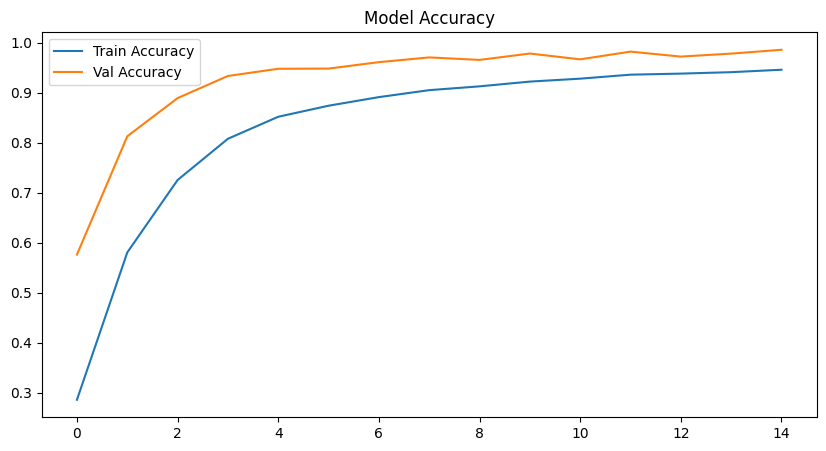

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Model Accuracy')

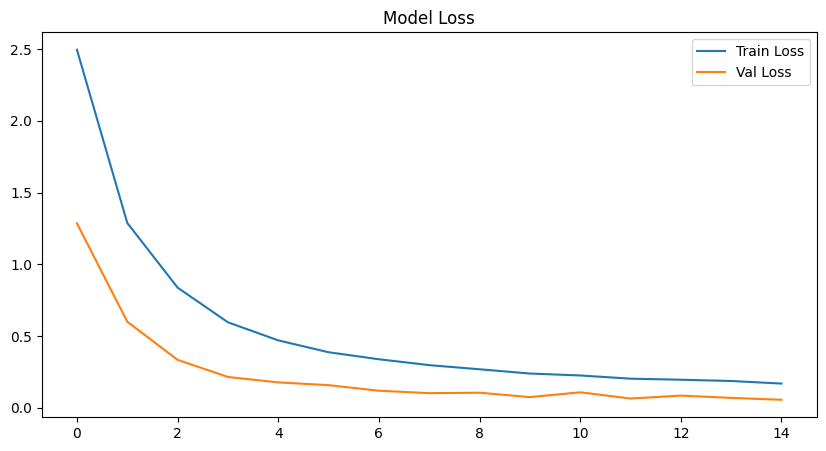

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


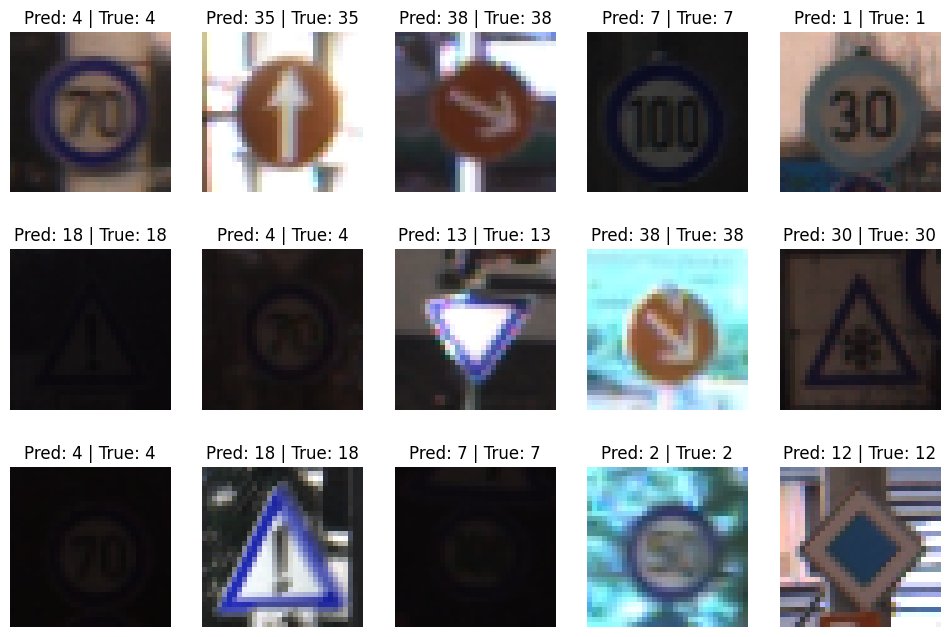

In [20]:
def predict_sample_images():
    fig, axes = plt.subplots(3, 5 , figsize=(12, 8))
    for i, ax in enumerate(axes.flat):
        img = X_test[i]
        true_label = np.argmax(y_test[i])
        pred_label = np.argmax(model.predict(img.reshape(1, 32, 32, 3)))
        ax.imshow(img)
        ax.set_title(f"Pred: {pred_label} | True: {true_label}")
        ax.axis('off')
    plt.show()

predict_sample_images()

In [21]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

In [22]:
model.save("cnn_recognition_model.h5")

In [23]:
!pip install tf2onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.0 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.


In [24]:
!pip install onnx

In [29]:
import tf2onnx
import onnx
import tensorflow as tf

model = tf.keras.models.load_model("cnn_recognition_model.h5")
# print("Model Input Shape:", model.input_shape)
# print(model.inputs[0].dtype)

class NCHWWrapper(tf.keras.Model):
  def __init__(self, model):
    super(NCHWWrapper, self).__init__()
    self.model = model

    def call(self, inputs):
      inputs = tf.transpose(inputs, [0, 2, 3, 1])
      return self.model(inputs)


wrapped_model = NCHWWrapper(model)

spec = (tf.TensorSpec((None, 3, 32, 33), tf.float32, name="input"),)
wrapped_model.output_names=['output']

onnx_model, _ = tf2onnx.convert.from_keras(
    wrapped_model,
    input_signature=spec,
    opset=13
)

# Step 4: Save the ONNX model
onnx.save(onnx_model, "cnn_recognition_model_nchw.onnx")

print("✅ Model converted to ONNX and saved as model.onnx")

NotImplementedError: in user code:

    File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.11/dist-packages/keras/src/models/model.py", line 161, in call
        raise NotImplementedError(

    NotImplementedError: Exception encountered when calling NCHWWrapper.call().
    
    [1mModel NCHWWrapper does not have a `call()` method implemented.[0m
    
    Arguments received by NCHWWrapper.call():
      • args=('tf.Tensor(shape=(None, 3, 32, 33), dtype=float32)',)
      • kwargs=<class 'inspect._empty'>


In [31]:
import tensorflow as tf
import tf2onnx
import onnx

# Load original model
model = tf.keras.models.load_model("cnn_recognition_model.h5")

# ✅ Wrap with a new model that expects NCHW input
class NCHWWrapper(tf.keras.Model):
    def __init__(self, model):
        super(NCHWWrapper, self).__init__()
        self.model = model

    def call(self, inputs):
        # Transpose from NCHW [N, C, H, W] to NHWC [N, H, W, C]
        x = tf.transpose(inputs, [0, 2, 3, 1])
        return self.model(x)

# Wrap your original model
wrapped_model = NCHWWrapper(model)
wrapped_model.output_names=['output']

# Define input spec in NCHW format for OpenCV: [None, 3, 32, 32]
spec = (tf.TensorSpec((None, 3, 32, 32), tf.float32, name="input"),)

# Convert to ONNX
onnx_model, _ = tf2onnx.convert.from_keras(
    wrapped_model,
    input_signature=spec,
    opset=13
)

# Save it
onnx.save(onnx_model, "cnn_recognition_model_nchw.onnx")
print("✅ Model converted and saved as cnn_recognition_model_nchw.onnx")


ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x79b352a62160>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


✅ Model converted and saved as cnn_recognition_model_nchw.onnx


In [ ]:
# import pandas as pd

# df = pd.read_csv(os.path.join(data_dir, "Test.csv"))
# # train_csv = pd.read_csv(os.path.join(data_dir, "Train.csv"))

# mini_df = df.iloc[:101][['Path', 'ClassId']]

# mini_df.to_csv("mini_test_labels.csv", index=False)